# Working Example
## Multi-variate, Multi-step Time Series Prediction w/ LSTM

Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import tqdm
%matplotlib inline

Load Data

In [2]:
if True:
    keep_col = list(range(1,18))

    df_day = pd.read_csv('Clean Data/ECL_Clean_Day.csv', 
                         infer_datetime_format=True,
                         parse_dates=['Timestamp'], 
                         index_col=['Timestamp'],
                         usecols = keep_col,
                         date_parser=lambda col: pd.to_datetime(col, utc=True).tz_convert('America/New_York'))

    #df_day.dtypes
    print (df_day.shape,'\n')
    print (df_day.head(3))

(5031, 16) 

                             Open    High     Low   Close   Volume  SMA_10  \
Timestamp                                                                    
2000-01-03 00:00:00-05:00  19.500  19.500  18.750  18.813   580000     NaN   
2000-01-04 00:00:00-05:00  18.813  18.969   9.000   9.188  1528798     NaN   
2000-01-05 00:00:00-05:00   9.250  19.188   9.188  19.063   700200     NaN   

                           SMA_50  EMA_10  EMA_50         RSI  ROC  MACD_Line  \
Timestamp                                                                       
2000-01-03 00:00:00-05:00     NaN     NaN     NaN  100.000000  NaN        NaN   
2000-01-04 00:00:00-05:00     NaN     NaN     NaN    0.000000  NaN        NaN   
2000-01-05 00:00:00-05:00     NaN     NaN     NaN   52.491694  NaN        NaN   

                           MACD_Diff  MACD_Sig  WO  ATR  
Timestamp                                                
2000-01-03 00:00:00-05:00        NaN       NaN NaN  0.0  
2000-01-04 00:00

Slice the data to get the 10 most recent years (2010 through 2019)

In [3]:
# create 10 years of data from 2019 - 2010

day_data = df_day[df_day.index >= '2010-01-01']
day_data.shape

(2516, 16)

Slice the data for the first 5 columns (Open, High, Low, Close, Volume) and then rearrange with Close price as the last column.

In [4]:
#slice for the first 4 cols only
data = day_data.loc[:,'Open':'Close']

#rearrange column order
data = data[['Open', 'High', 'Low', 'Close']]
print (data.shape)
data.head(3)

(2516, 4)


,Open,High,Low,Close
Timestamp,,,,
2010-01-04 00:00:00-05:00,45.08,45.3392,44.86,45.23
2010-01-05 00:00:00-05:00,45.12,45.1400,44.31,44.51
2010-01-06 00:00:00-05:00,44.49,44.8500,44.15,44.41


Function borrowed from Jason Brownlee's amazing website: [www.machinelearningmastery.com]

In [5]:
#from: machinelearningmastery.com/blog/

def time_series_to_supervised(data, n_lag=1, n_fut=1, selLag=None, selFut=None, dropnan=True):
    """
    Converts a time series to a supervised learning data set by adding time-shifted prior and future period
    data as input or output (i.e., target result) columns for each period
    :param data:  a series of periodic attributes as a list or NumPy array
    :param n_lag: number of PRIOR periods to lag as input (X); generates: Xa(t-1), Xa(t-2); min= 0 --> nothing lagged
    :param n_fut: number of FUTURE periods to add as target output (y); generates Yout(t+1); min= 0 --> no future periods
    :param selLag:  only copy these specific PRIOR period attributes; default= None; EX: ['Xa', 'Xb' ]
    :param selFut:  only copy these specific FUTURE period attributes; default= None; EX: ['rslt', 'xx']
    :param dropnan: True= drop rows with NaN values; default= True
    :return: a Pandas DataFrame of time series data organized for supervised learning
    NOTES:
    (1) The current period's data is always included in the output.
    (2) A suffix is added to the original column names to indicate a relative time reference: e.g., (t) is the current
        period; (t-2) is from two periods in the past; (t+1) is from the next period
    (3) This is an extension of Jason Brownlee's series_to_supervised() function, customized for MFI use
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    origNames = df.columns
    cols, names = list(), list()
    # include all current period attributes
    cols.append(df.shift(0))
    names += [('%s' % origNames[j]) for j in range(n_vars)]
 
    # lag any past period attributes (t-n_lag,...,t-1)
    n_lag = max(0, n_lag)  # force valid number of lag periods
    for i in range(n_lag, 0, -1):
        suffix= '(t-%d)' % i
        if (None == selLag):   # copy all attributes from PRIOR periods?
            cols.append(df.shift(i))
            names += [('%s%s' % (origNames[j], suffix)) for j in range(n_vars)]
        else:
            for var in (selLag):
                cols.append(df[var].shift(i))
                names+= [('%s%s' % (var, suffix))]
 
    # include future period attributes (t+1,...,t+n_fut)
    n_fut = max(n_fut, 0)  # force valid number of future periods to shift back
    for i in range(1, n_fut + 1):
        suffix= '(t+%d)' % i
        if (None == selFut):  # copy all attributes from future periods?
            cols.append(df.shift(-i))
            names += [('%s%s' % (origNames[j], suffix)) for j in range(n_vars)]
        else:  # copy only selected future attributes
            for var in (selFut):
                cols.append(df[var].shift(-i))
                names += [('%s%s' % (var, suffix))]
    # combine everything
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values introduced by lagging
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Problem Framing:
* Multivariate (Open, High, Low, Close, Volume)
* Univariate, multistep output (Close)
* Predict the next 30 days Close price using the previous 30 days

Therefore:
* n_in = 30
* n_out = 30
* n_features = 4

Rerrange the data to a supervised learning problem using the `time_series_to_supervised` function.

In [6]:
data = time_series_to_supervised(data, n_lag=30, n_fut=30, selFut=['Close'])

As expected, we end up with 30 * 4 + 30 * 1 + 4 = 154 columns. That splits as:
* 30 x 4 = n_in x n_features (in)
* 30 x 4 = n_out x n_features (out)
* 1 x 4 = n_features a time t

In [7]:
data.shape

(2456, 154)

In [8]:
for i in data.columns:
    print (i)

Open
High
Low
Close
Open(t-30)
High(t-30)
Low(t-30)
Close(t-30)
Open(t-29)
High(t-29)
Low(t-29)
Close(t-29)
Open(t-28)
High(t-28)
Low(t-28)
Close(t-28)
Open(t-27)
High(t-27)
Low(t-27)
Close(t-27)
Open(t-26)
High(t-26)
Low(t-26)
Close(t-26)
Open(t-25)
High(t-25)
Low(t-25)
Close(t-25)
Open(t-24)
High(t-24)
Low(t-24)
Close(t-24)
Open(t-23)
High(t-23)
Low(t-23)
Close(t-23)
Open(t-22)
High(t-22)
Low(t-22)
Close(t-22)
Open(t-21)
High(t-21)
Low(t-21)
Close(t-21)
Open(t-20)
High(t-20)
Low(t-20)
Close(t-20)
Open(t-19)
High(t-19)
Low(t-19)
Close(t-19)
Open(t-18)
High(t-18)
Low(t-18)
Close(t-18)
Open(t-17)
High(t-17)
Low(t-17)
Close(t-17)
Open(t-16)
High(t-16)
Low(t-16)
Close(t-16)
Open(t-15)
High(t-15)
Low(t-15)
Close(t-15)
Open(t-14)
High(t-14)
Low(t-14)
Close(t-14)
Open(t-13)
High(t-13)
Low(t-13)
Close(t-13)
Open(t-12)
High(t-12)
Low(t-12)
Close(t-12)
Open(t-11)
High(t-11)
Low(t-11)
Close(t-11)
Open(t-10)
High(t-10)
Low(t-10)
Close(t-10)
Open(t-9)
High(t-9)
Low(t-9)
Close(t-9)
Open(t-8)
High(t

Split the data into train and test based on a date. That gives 7 years for training and 3 years for testing.

In [9]:
cut_off = '2017-01-01'
train = data[data.index < cut_off].values
test = data[data.index > cut_off].values
print (train.shape, test.shape)

(1732, 154) (724, 154)


Reshape the data for LSTM

In [10]:
n_features = 4
n_in, n_out = 30, 30

# 5 features, 3 timesteps lag
n_obs = n_features * n_in

# split X, y
X_train, y_train = train[:, :n_obs], train[:, -n_out:] #-n_features
X_test, y_test = test[:, :n_obs], test[:, -n_out:] #-n_features
print('Shape of splits:')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape,'\n')

# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], n_in, n_features))
X_test = X_test.reshape((X_test.shape[0], n_in, n_features))
print('Re-shaped for LSTM:')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Shape of splits:
(1732, 120) (1732, 30) (724, 120) (724, 30) 

Re-shaped for LSTM:
(1732, 30, 4) (1732, 30) (724, 30, 4) (724, 30)


Define a simple stacked LSTM model and train it

In [11]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

Using TensorFlow backend.
/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/jacobscottant

In [12]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=((X_train.shape[1]), X_train.shape[2])))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_out))
model.compile(optimizer='adam', loss='mae')

In [13]:
history = model.fit(X_train, y_train, 
                    epochs=10, batch_size=30, 
                    validation_data=(X_test, y_test), 
                    verbose=1, shuffle=False)


Train on 1732 samples, validate on 724 samples
Epoch 1/10
1732/1732 [==============================] - 4s 2ms/step - loss: 27.2950 - val_loss: 49.2617
Epoch 2/10
1732/1732 [==============================] - 3s 2ms/step - loss: 34.2263 - val_loss: 37.6263
Epoch 3/10
1732/1732 [==============================] - 3s 2ms/step - loss: 13.7547 - val_loss: 24.8624
Epoch 4/10
1732/1732 [==============================] - 4s 2ms/step - loss: 7.1224 - val_loss: 7.6258
Epoch 5/10
1732/1732 [==============================] - 4s 2ms/step - loss: 24.1861 - val_loss: 699.0815
Epoch 6/10
1732/1732 [==============================] - 4s 2ms/step - loss: 72.3839 - val_loss: 96.4650
Epoch 7/10
1732/1732 [==============================] - 5s 3ms/step - loss: 11.1386 - val_loss: 6.0562
Epoch 8/10
1732/1732 [==============================] - 4s 2ms/step - loss: 3.7407 - val_loss: 6.3773
Epoch 9/10
1732/1732 [==============================] - 4s 2ms/step - loss: 3.7176 - val_loss: 5.5631
Epoch 10/10
1732/1732 

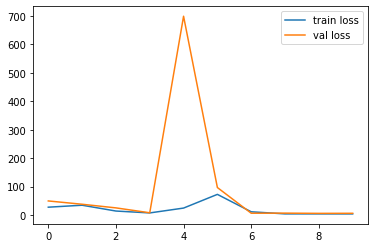

In [14]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

Model performance is poor but that's irrelevant at this stage. I'll grid search this later.

In [15]:
print (X_test[0].shape)
X_test[0]

(30, 4)


array([[117.58  , 118.41  , 117.29  , 118.03  ],
       [114.31  , 114.88  , 114.115 , 114.84  ],
       [114.83  , 115.27  , 114.09  , 114.31  ],
       [114.9   , 115.23  , 114.36  , 114.91  ],
       [115.058 , 116.56  , 114.91  , 116.39  ],
       [116.34  , 117.44  , 116.34  , 116.77  ],
       [116.84  , 116.84  , 116.12  , 116.56  ],
       [116.61  , 117.    , 116.05  , 116.33  ],
       [116.23  , 116.98  , 115.78  , 116.41  ],
       [116.7359, 117.37  , 116.16  , 116.695 ],
       [117.    , 118.55  , 116.88  , 118.49  ],
       [118.457 , 118.72  , 116.41  , 116.81  ],
       [117.32  , 119.05  , 117.    , 118.56  ],
       [118.21  , 118.38  , 116.42  , 116.91  ],
       [116.85  , 118.82  , 116.64  , 118.78  ],
       [118.8158, 119.76  , 118.42  , 119.56  ],
       [119.34  , 120.51  , 119.31  , 120.5   ],
       [120.98  , 121.81  , 120.485 , 121.48  ],
       [121.88  , 122.25  , 121.25  , 122.18  ],
       [121.9947, 122.23  , 120.83  , 121.03  ],
       [120.28  , 12

In [16]:
print (y_test[0].shape)
y_test[0]

(30,)


array([118.79, 118.55, 118.93, 118.85, 117.81, 118.31, 118.65, 118.56,
       118.67, 119.09, 118.83, 118.4 , 119.35, 121.65, 122.49, 120.98,
       121.29, 121.46, 120.16, 120.77, 120.2 , 120.73, 119.68, 120.18,
       120.33, 120.55, 121.11, 121.76, 122.79, 123.39])

In [17]:
# make a prediction

x_input = X_test[0].reshape((1, n_in, n_features))
yhat = model.predict(x_input)

In [18]:
print (yhat[0].shape)
yhat

(30,)


array([[117.55981 , 117.97164 , 117.84043 , 116.73865 , 116.76366 ,
        118.07057 , 116.97775 , 117.90622 , 117.992935, 118.63302 ,
        118.34768 , 118.857216, 119.265785, 118.723465, 119.229805,
        119.54427 , 119.77735 , 120.544945, 120.05347 , 120.49492 ,
        120.001045, 120.53897 , 120.95416 , 121.19434 , 121.110855,
        121.432076, 121.76469 , 121.85692 , 121.88855 , 121.50028 ]],
      dtype=float32)

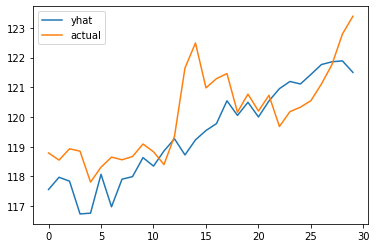

In [19]:
plt.plot(yhat[0], label='yhat')
plt.plot(y_test[0], label='actual')
plt.legend()
plt.show()

In [20]:
rmse = metrics.mean_squared_error(y_test[0], yhat[0])
print ('Root Mean Squared Error:',rmse)

Root Mean Squared Error: 1.5463336182845027


# (Now) Working Example as of 28/02/20
## Multi-variate, Multi-step Time Series Prediction w/ LSTM using SCALED data
Everything is the same, except I want to standardize the input data using MinMaxScaler as I'm planning to add in a bunch of additional features that are of vastly different magnitudes. <br>I'll start by copying the supervised learning dataframe.

In [21]:
data_test = data.copy()
data_test.shape

(2456, 154)

In [22]:
#Checking what it looks like

data_test.head(1)

,Open,High,Low,Close,Open(t-30),High(t-30),Low(t-30),Close(t-30),Open(t-29),High(t-29),...,Close(t+21),Close(t+22),Close(t+23),Close(t+24),Close(t+25),Close(t+26),Close(t+27),Close(t+28),Close(t+29),Close(t+30)
Timestamp,,,,,,,,,,,,,,,,,,,,,
2010-02-17 00:00:00-05:00,42.3,42.62,42.09,42.37,45.08,45.3392,44.86,45.23,45.12,45.14,...,43.1789,43.18,43.41,43.445,43.3203,43.12,43.5,43.66,43.91,43.96


In [23]:
#breaking down the problem one level deeper than above

n_features_in = 4
n_features_out = 1
n_lags_in = 30
n_lags_out = 30

n_obs_in = (n_features_in * n_lags_in)
n_obs_out = (n_features_out * n_lags_out)
print ('Number of observations in:',n_obs_in)
print ('Number of predictions out:', n_obs_out)

# Creating X, y from data_test
X = data_test.values[:, :n_obs_in]
y = data_test.values[:, -n_obs_out:]
print ('\nShape of X:',X.shape)
print ('Shape of y:', y.shape)

Number of observations in: 120
Number of predictions out: 30

Shape of X: (2456, 120)
Shape of y: (2456, 30)


In [24]:
#Just checking which columns landed where...

if True:
    for i in data_test.columns[:n_obs_in]:
        print (i)

Open
High
Low
Close
Open(t-30)
High(t-30)
Low(t-30)
Close(t-30)
Open(t-29)
High(t-29)
Low(t-29)
Close(t-29)
Open(t-28)
High(t-28)
Low(t-28)
Close(t-28)
Open(t-27)
High(t-27)
Low(t-27)
Close(t-27)
Open(t-26)
High(t-26)
Low(t-26)
Close(t-26)
Open(t-25)
High(t-25)
Low(t-25)
Close(t-25)
Open(t-24)
High(t-24)
Low(t-24)
Close(t-24)
Open(t-23)
High(t-23)
Low(t-23)
Close(t-23)
Open(t-22)
High(t-22)
Low(t-22)
Close(t-22)
Open(t-21)
High(t-21)
Low(t-21)
Close(t-21)
Open(t-20)
High(t-20)
Low(t-20)
Close(t-20)
Open(t-19)
High(t-19)
Low(t-19)
Close(t-19)
Open(t-18)
High(t-18)
Low(t-18)
Close(t-18)
Open(t-17)
High(t-17)
Low(t-17)
Close(t-17)
Open(t-16)
High(t-16)
Low(t-16)
Close(t-16)
Open(t-15)
High(t-15)
Low(t-15)
Close(t-15)
Open(t-14)
High(t-14)
Low(t-14)
Close(t-14)
Open(t-13)
High(t-13)
Low(t-13)
Close(t-13)
Open(t-12)
High(t-12)
Low(t-12)
Close(t-12)
Open(t-11)
High(t-11)
Low(t-11)
Close(t-11)
Open(t-10)
High(t-10)
Low(t-10)
Close(t-10)
Open(t-9)
High(t-9)
Low(t-9)
Close(t-9)
Open(t-8)
High(t

In [25]:
#Just checking which columns landed where...

if False:
    for i in data_test.columns[-n_obs_out:]:
        print (i)

In [26]:
#Initializing a separate scaler for X and y

from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler(feature_range=(0,1)).fit(X)
y_scaler = MinMaxScaler(feature_range=(0,1)).fit(y)

#X_scaled = X_scaler.fit_transform(X)
#y_scaled = y_scaler.fit_transform(y)

#print (X_scaled.shape, y_scaled.shape)

In [27]:
#Split X, y into X_train/X_test and y_train and y_test

n_train = 1732 # splits on dates as above except by index
n_features = 4
n_lag = 30
n_in, n_out = 30, 30

# split X, y into train/test
X_train, y_train = X[:n_train, :], y[:n_train, :]
X_test, y_test = X[n_train:, :], y[n_train:, :]
print('Shape of splits:')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Shape of splits:
(1732, 120) (1732, 30) (724, 120) (724, 30)


In [28]:
# Using the X,y scalers, scale the data

X_train, y_train = X_scaler.transform(X_train), y_scaler.transform(y_train)
X_test, y_test = X_scaler.transform(X_test), y_scaler.transform(y_test)

In [29]:
#Just checking what the scaling looks like

if False:
    print (X_train[0])

In [30]:
# reshape input to be 3D [samples, timesteps, features] for LSTM

X_train = X_train.reshape((X_train.shape[0], n_lag, n_features))
X_test = X_test.reshape((X_test.shape[0], n_lag, n_features))
print('Re-shaped for LSTM:')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Re-shaped for LSTM:
(1732, 30, 4) (1732, 30) (724, 30, 4) (724, 30)


Same shape as example above. We'll initialize a new model with the same architecture as above and train it.

In [31]:
model_test = Sequential()
model_test.add(LSTM(100, activation='relu', return_sequences=True, input_shape=((X_train.shape[1]), X_train.shape[2])))
model_test.add(LSTM(100, activation='relu'))
model_test.add(Dense(n_out))
model_test.compile(optimizer='adam', loss='mae')

In [32]:
history_test = model_test.fit(X_train, y_train, 
                    epochs=20, batch_size=30, 
                    validation_data=(X_test, y_test), 
                    verbose=1, shuffle=False)

Train on 1732 samples, validate on 724 samples
Epoch 1/20
1732/1732 [==============================] - 5s 3ms/step - loss: 0.0345 - val_loss: 0.1673
Epoch 2/20
1732/1732 [==============================] - 4s 2ms/step - loss: 0.0613 - val_loss: 0.0431
Epoch 3/20
1732/1732 [==============================] - 4s 2ms/step - loss: 0.0640 - val_loss: 0.0630
Epoch 4/20
1732/1732 [==============================] - 4s 2ms/step - loss: 0.0571 - val_loss: 0.0816
Epoch 5/20
1732/1732 [==============================] - 5s 3ms/step - loss: 0.0490 - val_loss: 0.0759
Epoch 6/20
1732/1732 [==============================] - 4s 2ms/step - loss: 0.0333 - val_loss: 0.0767
Epoch 7/20
1732/1732 [==============================] - 4s 2ms/step - loss: 0.0297 - val_loss: 0.0944
Epoch 8/20
1732/1732 [==============================] - 4s 2ms/step - loss: 0.0268 - val_loss: 0.1083
Epoch 9/20
1732/1732 [==============================] - 4s 2ms/step - loss: 0.0280 - val_loss: 0.1209
Epoch 10/20
1732/1732 [============

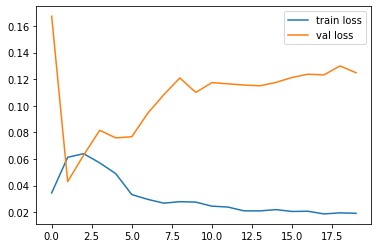

In [33]:
plt.plot(history_test.history['loss'], label='train loss')
plt.plot(history_test.history['val_loss'], label='val loss')
plt.legend()
plt.show()

Model performance is again poor but this isn't relevant now. I'll grid search a better architecture later. I'll first try and make a single prediction from X_test[0]

In [34]:
# checking the shape of X_test[0] for a single prediction

X_test[0].shape

(30, 4)

In [35]:
# reshape X_test[0] into 3D

x_input = X_test[0].reshape((1, n_lag, n_features))
print ('x_input shape: ',x_input.shape)

# make the prediction
yhat = model_test.predict(x_input)

x_input shape:  (1, 30, 4)


In [36]:
# checking the shape of yhat
print (yhat.shape)
yhat

(1, 30)


array([[0.4818532 , 0.4782744 , 0.47758964, 0.48086113, 0.4838239 ,
        0.48138437, 0.48056316, 0.47597712, 0.48074657, 0.4812854 ,
        0.47459772, 0.47710896, 0.4798409 , 0.47248513, 0.4741606 ,
        0.47355908, 0.47065055, 0.47075257, 0.47390115, 0.46902585,
        0.46966043, 0.4696836 , 0.4726638 , 0.47087693, 0.46903178,
        0.47339305, 0.46730208, 0.46715066, 0.4646973 , 0.4655745 ]],
      dtype=float32)

In [37]:
#invert the scaling for yhat using the y_scaler from above

inv_yhat = y_scaler.inverse_transform(yhat)
inv_yhat

array([[122.06612 , 121.46878 , 121.354485, 121.900536, 122.58087 ,
        122.22643 , 122.08974 , 121.3788  , 122.172195, 122.45256 ,
        121.34252 , 121.759346, 122.2128  , 120.991875, 121.26997 ,
        121.22924 , 120.97972 , 120.9966  , 121.51746 , 120.710945,
        120.815926, 120.819756, 121.312775, 121.017166, 120.71193 ,
        121.43341 , 120.628204, 120.68847 , 120.41777 , 120.583565]],
      dtype=float32)

In [38]:
#checking the shape of y_test[0]

print (y_test[0].shape)
y_test[0]

(30,)


array([0.46222515, 0.46078725, 0.46306393, 0.46258463, 0.45517863,
       0.45785521, 0.45989787, 0.45903216, 0.45969342, 0.46102687,
       0.45946044, 0.4568698 , 0.4625933 , 0.4764502 , 0.48151098,
       0.47205643, 0.47252614, 0.47355377, 0.46569546, 0.46938282,
       0.46593725, 0.46914103, 0.46279393, 0.46581636, 0.46672309,
       0.46805295, 0.47022115, 0.4736491 , 0.47910593, 0.48262454])

In [39]:
#reshape y_test

inv_y = y_test[0].reshape(1, y_test[0].shape[0])
inv_y.shape

(1, 30)

In [40]:
#invert the scaling for y_test

inv_y = y_scaler.inverse_transform(inv_y)
inv_y

array([[118.79, 118.55, 118.93, 118.85, 117.81, 118.31, 118.65, 118.56,
        118.67, 119.09, 118.83, 118.4 , 119.35, 121.65, 122.49, 120.98,
        121.29, 121.46, 120.16, 120.77, 120.2 , 120.73, 119.68, 120.18,
        120.33, 120.55, 121.11, 121.76, 122.79, 123.39]])

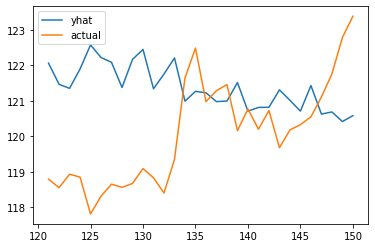

In [41]:
#plot inv_yhat and inv_y

plt.plot(range(121, 151), inv_yhat[0], label='yhat')
plt.plot(range(121, 151), inv_y[0], label='actual')
plt.legend()
plt.show()

In [42]:
rmse = metrics.mean_squared_error(inv_y, inv_yhat)
print ('Root Mean Squared Error:',rmse)

Root Mean Squared Error: 5.512808478367576


Predict the entire X_test in one go

In [43]:
#make the prediction
yhat_entire = model_test.predict(X_test)

#print the shape
print (yhat_entire.shape)

(724, 30)


In [44]:
#invert scaling for yhat using y_scaler
inv_yhat_entire = y_scaler.inverse_transform(yhat_entire)

print ('inv_yhat_entire shape:',inv_yhat_entire.shape)

inv_yhat_entire shape: (724, 30)


In [45]:
#prediction for X_test[0]

inv_yhat_entire[0]

array([122.06612 , 121.46877 , 121.35449 , 121.900536, 122.58087 ,
       122.22643 , 122.08974 , 121.37879 , 122.1722  , 122.45256 ,
       121.34253 , 121.759346, 122.2128  , 120.99186 , 121.26997 ,
       121.22924 , 120.97973 , 120.996605, 121.51746 , 120.710945,
       120.815926, 120.819756, 121.31276 , 121.01717 , 120.71193 ,
       121.43341 , 120.6282  , 120.68846 , 120.41777 , 120.58357 ],
      dtype=float32)

Comparing this to the prediction above, I can see they are the same :-)

In [46]:
#slicing on [:, 0] means we're taking the first day ((t+1) column) of each prediction in order to draw the line

inv_yhat = inv_yhat_entire[:,0]

In [47]:
#invert y_test. we are slicing as above

inv_y = y_scaler.inverse_transform(y_test)
inv_y = inv_y[: ,0]

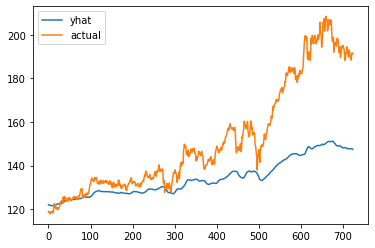

In [48]:
plt.plot(inv_yhat, label='yhat')
plt.plot(inv_y, label='actual')
plt.legend()
plt.show()

In [49]:
rmse = metrics.mean_squared_error(inv_y, inv_yhat)
print ('Root Mean Squared Error:',rmse)

Root Mean Squared Error: 590.6534095478053
